In [2]:
#importing necessary stuff
import pyarrow.parquet as pq
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import catboost as cat
from catboost import Pool, CatBoostClassifier, cv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [3]:
#read train data
train1 = pd.read_parquet('data/training_data/train1.parquet')
train2 = pd.read_parquet('data/training_data/train2.parquet')
train3 = pd.read_parquet('data/training_data/train3.parquet')

#concatenate data
train = pd.concat([train1, train2, train3], axis=0)

#read test data
test1 = pd.read_parquet('data/testing_data/test1.parquet')
test2 = pd.read_parquet('data/testing_data/test2.parquet')
test3 = pd.read_parquet('data/testing_data/test3.parquet')

#concatenate data
test = pd.concat([test1, test2, test3], axis=0)

In [4]:
#display the data and store the column in a list
train.head()
train.columns

Index(['security_product_name', 'machine_version', 'app_version',
       'av_sig_version', 'is_beta', 'rtp_state', 'is_sxs_passive',
       'default_browser', 'av_status', 'av_prod_installed', 'av_prod_enabled',
       'has_tpm', 'country_id', 'city_id', 'org_id', 'geo_id', 'local_name_id',
       'platform', 'processor', 'os_version', 'os_build', 'os_suite',
       'os_ptfm_sub_release', 'os_build_lab', 'sku_edition', 'is_protected',
       'auto_sample_opt_in', 'pua_mode', 's_mode', 'ie_ver_id', 'smart_screen',
       'firewall', 'uac_luaenable', 'mdc2_form_factor', 'device_family',
       'name_id', 'oem_model_id', 'core_count_processer', 'manufacturer_id',
       'model_id', 'processor_class', 'disk_capacity', 'disk_type',
       'system_volume_capacity', 'has_optical_drive', 'ram_capacity',
       'chassis_type', 'diagonal_display_size',
       'display_resolution_horizontal', 'display_resolution_vertical',
       'power_profile', 'battery_type', 'number_of_charges_for_battery',
 

In [5]:
#display the data and store the column in a list
test.head()
test.columns

Index(['security_product_name', 'machine_version', 'app_version',
       'av_sig_version', 'is_beta', 'rtp_state', 'is_sxs_passive',
       'default_browser', 'av_status', 'av_prod_installed', 'av_prod_enabled',
       'has_tpm', 'country_id', 'city_id', 'org_id', 'geo_id', 'local_name_id',
       'platform', 'processor', 'os_version', 'os_build', 'os_suite',
       'os_ptfm_sub_release', 'os_build_lab', 'sku_edition', 'is_protected',
       'auto_sample_opt_in', 'pua_mode', 's_mode', 'ie_ver_id', 'smart_screen',
       'firewall', 'uac_luaenable', 'mdc2_form_factor', 'device_family',
       'name_id', 'oem_model_id', 'core_count_processer', 'manufacturer_id',
       'model_id', 'processor_class', 'disk_capacity', 'disk_type',
       'system_volume_capacity', 'has_optical_drive', 'ram_capacity',
       'chassis_type', 'diagonal_display_size',
       'display_resolution_horizontal', 'display_resolution_vertical',
       'power_profile', 'battery_type', 'number_of_charges_for_battery',
 

In [6]:
#check for missing values
train.isnull().sum()
test.isnull().sum()

security_product_name         0
machine_version               0
app_version                   0
av_sig_version                0
is_beta                       0
                          ...  
pen_support                   0
aoac_support              31680
is_gamer                 134947
region_id                134947
machine_id                    0
Length: 82, dtype: int64

In [7]:
#find columns with >75% NA values and remove them
train = train.dropna(thresh=len(train)*0.25, axis=1)
test = test.dropna(thresh=len(test)*0.25, axis=1)

In [8]:
#remove columns with only one unique value
train = train.loc[:, train.nunique() != 1]
test = test.loc[:, test.nunique() != 1]

In [9]:
#imputation of missing values using mode
train = train.fillna(train.mode().iloc[0])
test = test.fillna(test.mode().iloc[0])

In [10]:
#label encoder
le = LabelEncoder()
for col in train.columns:
    if train[col].dtype == 'object':
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

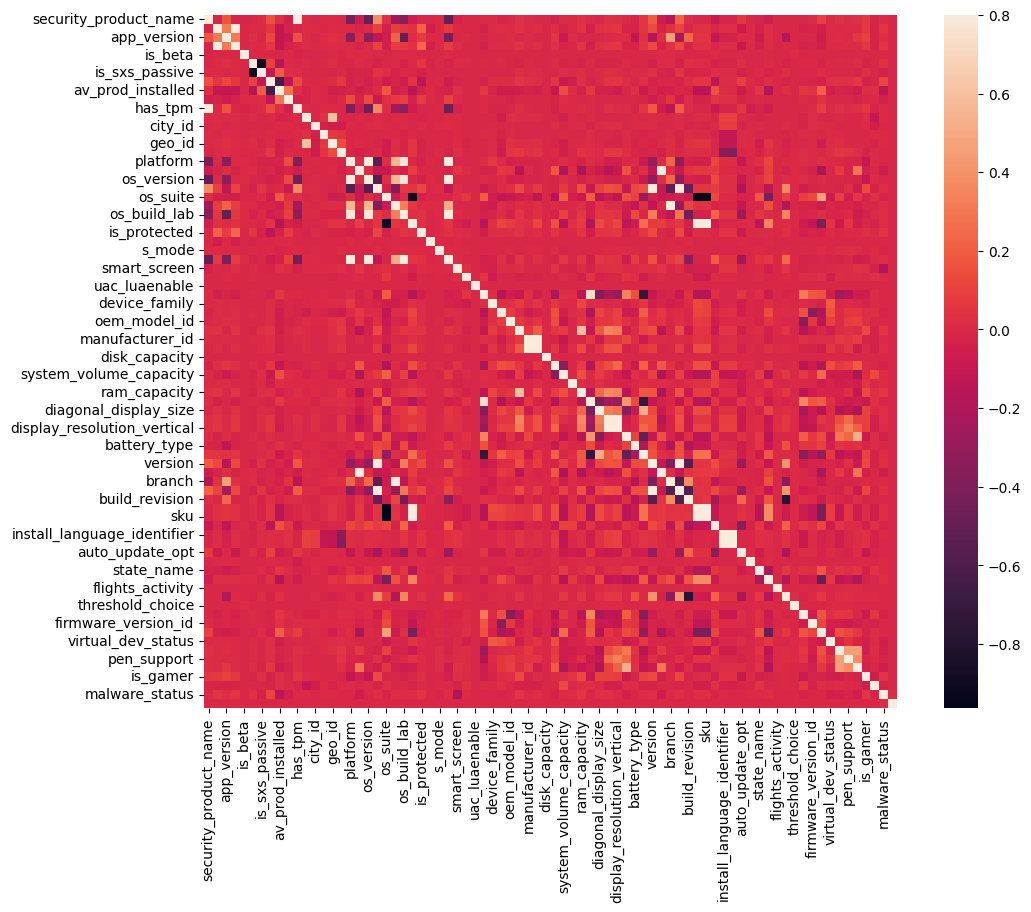

In [11]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [13]:
#removing columns based on correlation matrix where correlation is >0.9

for col in train.columns:
    if train[col].dtype == 'int64' or train[col].dtype == 'float64':
        if corrmat[col]['malware_status'] > 0.9:
            train = train.drop(col, axis=1)
            test = test.drop(col, axis=1)

In [14]:
#using naive bayes classifier, we can find the correlation between the features and the target
#target - malware_status
#identifier - machine_id

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(train.drop(['malware_status', 'machine_id'], axis=1), train['malware_status'], test_size=0.2, random_state=42)

#fitting the model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

#predicting the model
y_pred = gnb.predict(X_test)

#accuracy score
accuracy_score(y_test, y_pred)



0.5002751969023332

In [15]:
#find mislabeled data
mislabel = (y_test != y_pred).sum()
print(mislabel)

#find total data
total = len(y_test)
print(total)

#find percentage of mislabeled data
print(mislabel/total)


594701
1190057
0.49972480309766676


In [ ]:
'''
*Data Science- Round 2 (Final) Details*

Link:  https://www.kaggle.com/competitions/im-somewhat-of-a-cybersecurity-analyst-myself

1. The training data will be provided in a `CSV` format in the `training` directory
2. You’ll find 50 folds of the data in the `training/uploads/` directory.
    1. Here, you are expected to build the data loader using `pd.concat` and looping.
3. Once, you are done with this, you will be expected to build multiple models and train it using the training data generated from the previous step.
4. Next, you will be expected to get the predictions of the test data, in the expected format. The submission file contains:
    1. `machine_id`: An identifier to identify the machines
    2. `malware_status`: The output of the model (which is expected to be either 0 or 1).
5. Then just submit the above solution to Kaggle by converting the above to a csv format.
6. You will be ranked on a Public Leaderboard which is not a definite result as it will be tested on a portion of the test data.
7. The final ranks will be made available after the contests ends as you will expected to make you kernels/`.ipynb` files public on Kaggle.
    1. If this is not done, you WILL be disqualified even if you get the highest accuracy that your peers.
8. It is highly recommended to use the Kaggle kernels to build the models as you are free to use GPUs as well as TPUs as per your needs.

'''

In [17]:
#using decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6182913927652205
              precision    recall  f1-score   support

           0       0.62      0.62      0.62    595356
           1       0.62      0.62      0.62    594701

    accuracy                           0.62   1190057
   macro avg       0.62      0.62      0.62   1190057
weighted avg       0.62      0.62      0.62   1190057



In [1]:
#using random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


NameError: name 'X_train' is not defined

In [ ]:
#split the data into train and test
X = train.drop(['target'], axis=1)
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

KeyError: "['target'] not found in axis"